In [1]:
from typing import Annotated
from typing import Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, END,StateGraph, START
from langgraph.types import Command
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
import os
openai_api_key = os.getenv("OPENAI_KEY")
groq_model = ChatGroq(model='deepseek-r1-distill-llama-70b')
groq_model.invoke("Hello there").content

'<think>\n\n</think>\n\nHello! How can I assist you today? 😊'

In [4]:
def clean_text(text):
    import re
    clean_text = re.sub(r"<think>.*?</think>\s*", "", text, flags=re.DOTALL)
    return clean_text
response = groq_model.invoke("Hello there")
clean_text(response.content)

'Hello! How can I assist you today? 😊'

In [5]:
taviliy_tool = TavilySearchResults()
taviliy_tool.invoke("What is gdp?")

/tmp/ipykernel_37955/140375964.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  taviliy_tool = TavilySearchResults()


[{'title': 'Gross domestic product - Wikipedia',
  'url': 'https://en.wikipedia.org/wiki/Gross_domestic_product',
  'content': 'Gross domestic product (GDP) is a monetarymeasure of the total market value( of all the final goods and services produced and rendered in a specific time period by a country( or countries.( GDP is often used to measure the economic performance of a country or region.( Several national and international economic organizations maintain definitions of GDP, such as the OECD and the International Monetary Fund.( [...] GDP (Y) is the sum of consumption (C), investment (I), government expenditures (G) and net exports (X − M).\n\nY = C + I + G + (X − M)\nHere is a description of each GDP component: [...] GDP.',
  'score': 0.8969848},
 {'title': 'Beginners:GDP - What is gross domestic product (GDP)?',
  'url': 'https://ec.europa.eu/eurostat/statistics-explained/index.php/Beginners:GDP_-_What_is_gross_domestic_product_(GDP)%3F',
  'content': 'GDP "Glossary:Gross domesti

In [6]:
code = """
x = 5
y = x * 2
print(y)
"""

In [7]:
repl = PythonREPL()

In [8]:
repl.run(code)

Python REPL can execute arbitrary code. Use with caution.


'10\n'

In [9]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."]
):
    """
    Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user.

    """
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repl(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str
    

<>:14: SyntaxWarning: invalid escape sequence '\`'
<>:14: SyntaxWarning: invalid escape sequence '\`'
<>:14: SyntaxWarning: invalid escape sequence '\`'
<>:14: SyntaxWarning: invalid escape sequence '\`'
/tmp/ipykernel_37955/3774809755.py:14: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
/tmp/ipykernel_37955/3774809755.py:14: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [10]:
print(python_repl_tool.invoke(code))

Successfully executed:
\`\`\`python

x = 5
y = x * 2
print(y)

\`\`\`
Stdout: 10



In [11]:
members = ['researcher','coder']
options = members + ['FINISH']
options

['researcher', 'coder', 'FINISH']

In [12]:
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal['researcher', 'coder', 'FINISH']

In [13]:
class State(MessagesState):
    next: str

In [14]:
system_prompt = f"""
You are a supervisor, tasked with managing a conversation between the following workers: {members}. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status. 
When finished, respond with FINISH.
"""

In [15]:
[{"role": "system", "content": system_prompt},]

[{'role': 'system',
  'content': "\nYou are a supervisor, tasked with managing a conversation between the following workers: ['researcher', 'coder']. \nGiven the following user request, respond with the worker to act next. \nEach worker will perform a task and respond with their results and status. \nWhen finished, respond with FINISH.\n"}]

In [16]:
state = {"next":["hi"]}

In [17]:
[{"role": "system", "content": system_prompt},] + state["next"]

[{'role': 'system',
  'content': "\nYou are a supervisor, tasked with managing a conversation between the following workers: ['researcher', 'coder']. \nGiven the following user request, respond with the worker to act next. \nEach worker will perform a task and respond with their results and status. \nWhen finished, respond with FINISH.\n"},
 'hi']

In [18]:
def supervisor_node(state: State) -> Command[Literal["researcher", "coder", "__end__"]]: 
    messages = [{"role": "system", "content": system_prompt},] + state["messages"] 
    response = groq_model.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    print("below my goto**********************************")
    print(goto)
    
    if goto == "FINISH":
        goto = END      
    return Command(goto=goto, update={"next": goto})

In [19]:
def research_node(state: State) -> Command[Literal["supervisor"]]: 
    research_agent = create_react_agent(groq_model, tools=[taviliy_tool], prompt="You are a researcher. DO NOT do any math.") 
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )

In [20]:
def code_node(state: State) -> Command[Literal["supervisor"]]: 
    code_agent = create_react_agent(groq_model, tools=[python_repl_tool])
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )

In [21]:
graph=StateGraph(State)
graph.add_node("supervisor",supervisor_node)
graph.add_node("researcher", research_node)
graph.add_node("coder", code_node)
graph.add_edge(START,"supervisor")
app = graph.compile()

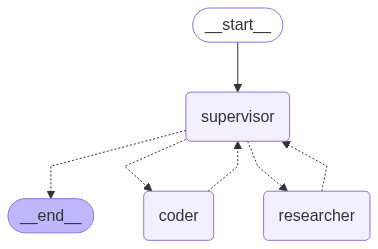

In [22]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [23]:
# With the graph created, we can now invoke it and see how it performs!
for s in app.stream({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True):
    print(s)
    print("----")

below my goto**********************************
researcher
((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:1f306fa0-9046-4d2e-d074-063b8b7ab0bd',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for the square root of 42. Hmm, I\'m a researcher and I can\'t do any math, but I have this tool called tavily_search_results_json that I can use. Let me think about how to approach this.\n\nFirst, I need to figure out a good search query to get the information. The square root of 42 isn\'t something I remember off the top of my head, so I should look it up. I\'ll try a straightforward query like "square root of 42" to get the most accurate results.\n\nI should make sure to use the tool correctly. The function requires a query parameter, so I\'ll structure the JSON with the name and arguments. The arguments should be an object with the query property set to my search string.\n\nOnce I call the tool, it should retur

Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel branch:to:__end__, ignoring it.


below my goto**********************************
FINISH
((), {'supervisor': {'next': '__end__'}})
----


In [24]:
app.invoke({"messages": [("user", "What's the square root of 42?")]}, subgraphs=True)

below my goto**********************************
coder
below my goto**********************************
researcher
below my goto**********************************
researcher
below my goto**********************************
researcher


Task supervisor with path ('__pregel_pull', 'supervisor') wrote to unknown channel branch:to:__end__, ignoring it.


below my goto**********************************
FINISH


{'messages': [HumanMessage(content="What's the square root of 42?", additional_kwargs={}, response_metadata={}, id='f3a22aa2-5140-468f-a67e-d62ac1349945'),
  HumanMessage(content='The square root of 42 is approximately **6.4807**.', additional_kwargs={}, response_metadata={}, name='coder', id='2cb3b7f5-f393-4c4b-8c7c-3a1cb9f76234'),
  HumanMessage(content='The square root of 42 is approximately **6.4807**.', additional_kwargs={}, response_metadata={}, name='researcher', id='d4a6a10f-cc0e-4216-b7a2-bea60cefec97'),
  HumanMessage(content='The square root of 42 is approximately **6.48**. This estimation is based on the understanding that 42 lies between the perfect squares 36 (6²) and 49 (7²), and further refined by calculating that 6.48 squared is very close to 42.', additional_kwargs={}, response_metadata={}, name='researcher', id='d37b60ad-aea4-426c-b268-9ba628af6f4d'),
  HumanMessage(content='\n\nTo find the square root of 42, I can use the fact that 42 lies between the perfect square

In [25]:
app.invoke({"messages": [("user", "What is an efficient Python code to get prime numbers?")]}, subgraphs=True)

below my goto**********************************
coder
below my goto**********************************
coder
below my goto**********************************
researcher
below my goto**********************************
researcher
below my goto**********************************
coder


BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '\nOkay, so I need to figure out an efficient way to get prime numbers using Python. I\'ve heard about the Sieve of Eratosthenes before, but I\'m not exactly sure how it works. Let me try to break it down.\n\nFirst, what is a prime number? Oh right, a prime number is a number greater than 1 that has no divisors other than 1 and itself. So, numbers like 2, 3, 5, 7, etc., are primes.\n\nNow, the Sieve of Eratosthenes... I think it\'s an ancient algorithm for finding all prime numbers up to a certain limit. The name sounds Greek, maybe named after someone named Eratosthenes.\n\nHow does it work? From what I remember, it\'s like a sieve that filters out non-prime numbers. You start with a list of numbers, and then you iteratively mark the multiples of each prime number starting from 2.\n\nLet me try to outline the steps:\n\n1. Create a list of boolean values representing numbers from 0 to the limit. Initially, all entries are set to True, meaning all numbers are considered prime at the start.\n2. Set the entries at indices 0 and 1 to False because 0 and 1 are not prime numbers.\n3. Start with the first prime number, which is 2. Mark all multiples of 2 as not prime.\n4. Move to the next number that is still marked as prime (which would be 3), and mark all its multiples as not prime.\n5. Continue this process up to the square root of the limit. Why the square root? Oh, because if a number has a factor larger than its square root, the corresponding smaller factor would have already been marked.\n6. After processing, collect all indices that are still marked as True. These are your prime numbers.\n\nWait, let me think about step 5 again. If I only go up to the square root of the limit, does that cover all possible non-prime numbers? For example, if the limit is 100, the square root is 10. So, checking up to 10 should be enough because any composite number larger than 10 would have factors less than or equal to 10.\n\nOkay, that makes sense. It reduces the number of iterations needed, making the algorithm more efficient.\n\nNow, how do I implement this in Python?\n\nI\'ll start by defining a function called `get_primes` that takes a `limit` as an argument. Inside the function:\n\n- If the limit is less than 2, return an empty list because there are no primes less than 2.\n- Create a boolean list `prime` of size `limit + 1`, initialized to `True`.\n- Set `prime[0]` and `prime[1]` to `False`.\n- Loop through each number starting from 2 up to the square root of the limit.\n- For each number, if it\'s still marked as prime, mark all its multiples starting from its square as not prime.\n- Finally, collect all indices that are still `True` and return them as the list of primes.\n\nLet me try to write this out step by step.\n\nFirst, handle the edge case where the limit is less than 2:\n\n```python\ndef get_primes(limit):\n    if limit < 2:\n        return []\n```\n\nNext, create the boolean list and initialize it:\n\n```python\n    prime = [True] * (limit + 1)\n    prime[0], prime[1] = False, False\n```\n\nNow, loop through each number from 2 to the square root of the limit:\n\n```python\n    for current_prime in range(2, int(limit ** 0.5) + 1):\n        if prime[current_prime]:\n            for multiple in range(current_prime * current_prime, limit + 1, current_prime):\n                prime[multiple] = False\n```\n\nWait, why start marking multiples from `current_prime * current_prime`? Oh, right, because smaller multiples would have already been marked by smaller primes. For example, multiples of 2 have already been marked when `current_prime` was 2, so when `current_prime` is 3, starting at 9 ensures we don\'t re-mark multiples that were already handled.\n\nFinally, collect the primes:\n\n```python\n    primes = [num for num, is_prime in enumerate(prime) if is_prime]\n    return primes\n```\n\nPutting it all together:\n\n```python\ndef get_primes(limit):\n    if limit < 2:\n        return []\n    \n    prime = [True] * (limit + 1)\n    prime[0], prime[1] = False, False\n    \n    for current_prime in range(2, int(limit ** 0.5) + 1):\n        if prime[current_prime]:\n            for multiple in range(current_prime * current_prime, limit + 1, current_prime):\n                prime[multiple] = False\n    \n    primes = [num for num, is_prime in enumerate(prime) if is_prime]\n    return primes\n\n# Example usage:\nprimes = get_primes(100)\nprint("Primes up to 100:", primes)\n```\n\nLet me test this code with a small limit to see if it works. For example, if the limit is 10, the primes should be [2, 3, 5, 7].\n\nRunning the code with `get_primes(10)` should return [2, 3, 5, 7].\n\nYes, that seems correct. Now, let\'s try with a larger number, like 100, as in the example. The output should list all primes up to 100.\n\nThis approach seems efficient and easy to understand. I think I\'ve got it!\n</think>\n\nTo efficiently find prime numbers in Python, you can use the Sieve of Eratosthenes algorithm. This method is highly efficient for generating all prime numbers up to a specified limit. Here\'s a step-by-step explanation and implementation:\n\n### Sieve of Eratosthenes Algorithm\n\n1. **Initialization**: Create a boolean list `prime` where each index represents whether the number is prime. Initially, all values are set to `True`, except for indices 0 and 1, which are set to `False` because 0 and 1 are not prime numbers.\n\n2. **Mark Non-Primes**: Iterate through each number starting from 2 up to the square root of the limit. For each number that is still marked as prime:\n   - Mark all its multiples as non-prime, starting from the square of the current prime number.\n\n3. **Collect Primes**: After processing, collect all indices that are still marked as `True` in the `prime` list. These indices represent the prime numbers up to the specified limit.\n\n### Python Implementation\n\n```python\ndef get_primes(limit):\n    if limit < 2:\n        return []\n    \n    # Create a boolean list where each index represents whether the number is prime\n    prime = [True] * (limit + 1)\n    prime[0], prime[1] = False, False  # 0 and 1 are not primes\n    \n    # Iterate from 2 to sqrt(limit)\n    for current_prime in range(2, int(limit ** 0.5) + 1):\n        if prime[current_prime]:  # If current_prime is a prime\n            # Mark multiples of current_prime starting from current_prime^2 as not prime\n            for multiple in range(current_prime * current_prime, limit + 1, current_prime):\n                prime[multiple] = False\n    \n    # Collect all indices that are still marked as True\n    primes = [num for num, is_prime in enumerate(prime) if is_prime]\n    return primes\n\n# Example usage:\nprimes = get_primes(100)\nprint("Primes up to 100:", primes)\n```\n\n### Explanation\n\n- **Initialization**: The boolean list `prime` is initialized to keep track of prime numbers. By default, all numbers are considered prime initially.\n- **Marking Non-Primes**: For each prime number starting from 2, the algorithm marks its multiples as non-prime. This starts from the square of the current prime to avoid redundant checks.\n- **Efficiency**: The algorithm runs in O(n log log n) time complexity, making it highly efficient for generating prime numbers up to a large limit.\n- **Example Usage**: The function `get_primes` is called with a limit of 100, and the resulting list of prime numbers is printed.\n\nThis implementation provides an efficient and clear method to generate prime numbers, ideal for both small and large limits.'}}